# Engineering Model  - Analog Chain -> CSP -> CBF -> SDP -> Analysis with pyuvdata

## Author: Lee Render and Alan Chen

### Analog Chain Setup/ Mapping to MCCS

The test setup mimics two stations with two antennas each. The 8 available channels of the Arbritrary Waveform generator are set to carry sinusoids signals for the X and Y polarisations outputs of the antennas into MCCS via the ITF Sky Signal Generator. The table below
shows the mapping between the various components along with signal strength, type and attenuation settings:

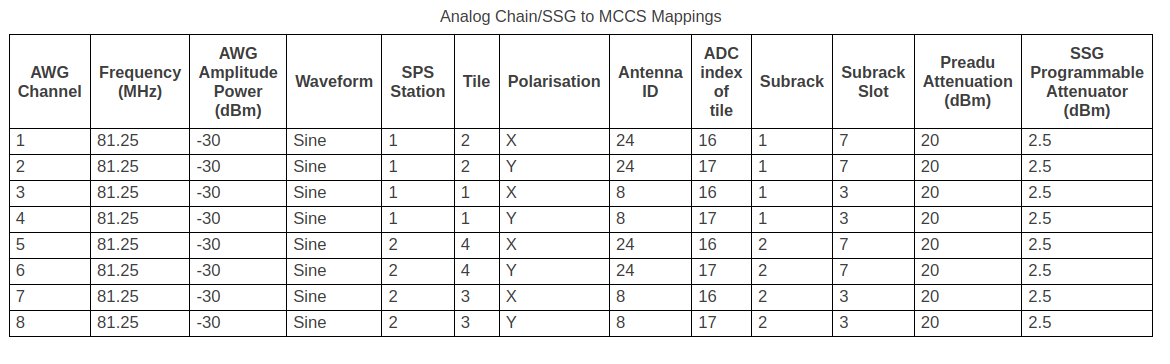

This notebook demonstrates the integration between between the Analog chain, CSP, CBF and SDP:

<div>
    <img src="attachment:24adb878-1b56-4c6d-8e73-a313aa3b4170.png" width="1000"/>
</div>    

## Precondition - smartboxes on!

In [ ]:
# pragma pylint: disable=line-too-long
# pragma pylint: disable=no-else-return
# pragma pylint: disable=consider-using-set-comprehension
# pragma pylint: disable=import-error
# pragma pylint: disable=too-many-function-args
# pragma pylint: disable=dangerous-default-value

In [ ]:
%run smartbox_checks.ipynb

## Precondition - connector ports setup

In [ ]:
%run setup_connector_ports.ipynb

## Install required packages

In [ ]:
!pip install tabulate

## Imports

In [ ]:
import json
import logging
import os
import random
import sys
import time
from datetime import date, datetime
from time import sleep

import astropy.units as u
import configuration
import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ska_sdp_config
import ska_ser_logging
import test_frame
import toolz
from astropy.time import Time
from pyuvdata import UVData
from ska_control_model import ObsState
from ska_k8s_config_exporter.utils import initialise_k8s
from tango import DeviceProxy, DevSource, DevState
from tango_utils import subarray_safe_release, wait_for_obs_state

from aiv_utils.low_utils import print_port_status

sys.path.append("/home/jovyan/ska-low-itf-scripts/database/scripts/support")
sys.path.append("/home/jovyan/ska-low-itf-scripts/database/scripts/scripts")

In [ ]:
RFC_FORMAT = "%Y-%m-%dT%H:%M:%S.%fZ"

logger = logging.getLogger(__name__)

## Chart Information

In [ ]:
charts = configuration.get_charts()
pods = configuration.get_pods()
tango_config = configuration.get_tango_config()

print("CHARTS")
display.as_json_tree(charts)
print("\nPODS")
display.as_json_tree(pods)
print("\nTANGO CONFIGURATION")
display.as_json_tree(tango_config)

## Constants

In [ ]:
TIMEOUT = 60.0
INTERVAL = 0.5
SAFE_PREADU_LEVEL = 20.0

## Pure helper functions
These functions operate only on their arguments and should be reusable in other notebooks

In [ ]:
def get_sut_device(fqdn):
    device = DeviceProxy(f"tango-databaseds.sut:10000/{fqdn}")
    # ensure we don't get cached data
    device.set_source(DevSource.DEV)
    return device


def get_te_device(fqdn):
    device = DeviceProxy(f"tango-databaseds.test-environment:10000/{fqdn}")
    # ensure we don't get cached data
    device.set_source(DevSource.DEV)
    return device

In [ ]:
def safe_power(tile, gain=1.0):
    return all(p * gain <= 120.0 for p in tile.adcpower)

In [ ]:
def wait_for_tpms(tiles, desired_state="Initialised"):
    n = len(tiles)
    num_good = 0
    while num_good != n:
        num_good = len(
            [tile for tile in tiles if tile.tileprogrammingstate == desired_state]
        )
        bad_tiles = [
            tile for tile in tiles if tile.tileprogrammingstate != desired_state
        ]
        print(f"{num_good} of {n} are {desired_state} ...")
        for tile in bad_tiles:
            print(
                f"{tile.name()} is {tile.tileprogrammingstate} not {desired_state} ..."
            )
        time.sleep(5)
    print(f"All tpms are {desired_state}")

In [ ]:
def wait_for_state(device, state, timeout=TIMEOUT):
    """
    Wait for device state to have the expected value.

    :param device: device client
    :param state: the expected state
    :param timeout: timeout in seconds
    """

    def predicate():
        return device.state() == state

    description = f"Device state {state.name}"
    logger.info(f"Waiting for device state {state.name}...")
    wait_for_predicate(predicate, description, timeout=timeout)


def wait_for_predicate(predicate, description, timeout=TIMEOUT, interval=INTERVAL):
    """
    Wait for predicate to be true.

    :param predicate: callable to test
    :param description: description to use if test fails
    :param timeout: timeout in seconds
    :param interval: interval between tests of the predicate in seconds

    """
    start = time.time()
    while True:
        if predicate():
            break
        if time.time() >= start + timeout:
            raise TimeoutError(f"{description} not achieved after {timeout} seconds")
        time.sleep(interval)

In [ ]:
def get_tiles(station):
    tile_fqdns = station.get_property("TileFQDNS")["TileFQDNS"]
    return [get_sut_device(fqdn) for fqdn in tile_fqdns]

In [ ]:
def check_logical_ids_station(station):
    ids = [tile.logicaltileid for tile in get_tiles(station)]
    assert ids == [0, 1], f"Expecting logical ids to be [0,1]: actual: {ids}"

In [ ]:
def show_tile_routing(tiles):
    table = []
    routes = []
    lines = []
    for tile in tiles:
        core_configs = json.loads(tile.get40gcoreconfiguration("{}"))
        for core_config in core_configs:
            core_id = core_config["core_id"]
            arp_table = core_config["arp_table_entry"]
            src_ip = core_config["source_ip"]
            dest_ip = core_config["destination_ip"]
            dest_port = core_config["destination_port"]
            if dest_ip == csp_ingest_ip:
                dest = "CSP"
            elif dest_ip == daq_ip:
                dest = "DAQ"
            else:
                dest = dest_ip
            routes.append(
                {
                    "tile": tile.name(),
                    "core": core_id,
                    "arp": arp_table,
                    "src": src_ip,
                    "dest": dest,
                    "port": dest_port,
                }
            )
    for route in routes:
        table.append(
            f"TILE {route['tile']} CORE {route['core']} ARP {route['arp']}: {route['src']} --> {route['dest']}/{route['port']}"
        )
    for line in sorted(table):
        lines.append(line)
        print(line)
    return "\n".join(lines)

In [ ]:
def get_tile_routes(tiles):
    routes = []
    for tile in tiles:
        core_configs = json.loads(tile.get40gcoreconfiguration("{}"))
        for core_config in core_configs:
            core_id = core_config["core_id"]
            arp_table = core_config["arp_table_entry"]
            src_ip = core_config["source_ip"]
            dest_ip = core_config["destination_ip"]
            dest_port = core_config["destination_port"]
            if dest_ip == csp_ingest_ip:
                dest = "CSP"
            elif dest_ip == daq_ip:
                dest = "DAQ"
            else:
                dest = dest_ip
            routes.append(
                {
                    "tile": tile.name(),
                    "core": core_id,
                    "arp": arp_table,
                    "src": src_ip,
                    "dest": dest,
                    "port": dest_port,
                }
            )
    return routes

In [ ]:
awg = get_te_device("low-itf/awg/1")  # Arbritrary Waveform Generator (AWG5208)

In [ ]:
prog_atten1 = get_te_device("low-itf/progattenuator/1")

In [ ]:
prog_atten2 = get_te_device("low-itf/progattenuator/2")

In [ ]:
subrack1 = get_sut_device("low-mccs/subrack/subrack1")

In [ ]:
subrack2 = get_sut_device("low-mccs/subrack/subrack2")

In [ ]:
tile1 = get_sut_device("low-mccs/tile/01")  # tile1 seems to be bad

In [ ]:
tile2 = get_sut_device("low-mccs/tile/02")

In [ ]:
tile3 = get_sut_device("low-mccs/tile/03")

In [ ]:
tile4 = get_sut_device("low-mccs/tile/04")

In [ ]:
connector = get_sut_device("low-cbf/connector/0")

In [ ]:
allocator = get_sut_device("low-cbf/allocator/0")

In [ ]:
station1 = get_sut_device("low-mccs/spsstation/station1")

In [ ]:
station2 = get_sut_device("low-mccs/spsstation/station2")

In [ ]:
pasdbus = get_sut_device("low-mccs/pasdbus/itf")

In [ ]:
sp6t = get_te_device("low-itf/sp6t/1")  # Switch Matrix (RC-2SP6T-A18)

In [ ]:
daq = get_sut_device("low-mccs/daqreceiver/station1")

In [ ]:
correlator = get_sut_device("low-cbf/processor/0.0.0")

In [ ]:
subracks = [subrack1, subrack2]

stations = [station1, station2]

devices = [
    awg,
    subrack1,
    subrack2,
    tile1,
    tile2,
    tile3,
    tile4,
    connector,
    prog_atten1,
    prog_atten2,
    allocator,
    station1,
    station2,
    sp6t,
    pasdbus,
]

station1_tiles = [tile1, tile2]
station2_tiles = [tile3, tile4]

In [ ]:
station1_frame = test_frame.TestFrame(
    station1_tiles, ["adminMode", "status", "tileprogrammingstate"]
)

In [ ]:
station2_frame = test_frame.TestFrame(
    station2_tiles, ["adminMode", "status", "tileprogrammingstate"]
)

## Non-pure helper functions
These functions use tango device names in the body without supplying them as arguments. This makes the function invocations shorter and more readable, but hinders reusability as the functions may not work if they are copied into another notebook.

In [ ]:
def stop_beamforming():
    station1.stop_beamforming()
    station2.stop_beamforming()

In [ ]:
def reset_smartbox_port_breaker(smartbox_number, smartbox_port):
    cmd = {"smartbox_number": smartbox_number, "port_number": smartbox_port}
    cmd_json = json.dumps(cmd)
    pasdbus.resetsmartboxportbreaker(cmd_json)

In [ ]:
def get_ports_with_breakers_set(sb):
    attr = f"smartbox{sb}portbreakerstripped"
    boolean_array = getattr(pasdbus, attr)
    # np.where returns a 1 tuple for a 1 dim array and port operations are 1 based
    ports = np.where(boolean_array)[0] + 1
    return ports

In [ ]:
def connect_to_switch():
    switch_config = {"Switch": "10.134.0.22:50052"}
    connector.connecttoswitch(json.dumps(switch_config))

In [ ]:
def setup_spead_routing(channels, dest_port, beam=0, clear=False):
    if clear:
        connector.ClearSpeadUnicastTable("")
    spead_cfg = {
        "spead": [
            {
                "src": {"frequency": channel, "beam": beam, "sub_array": 1},
                "dst": {"port": dest_port},
            }
            for channel in channels
        ]
    }

    try:
        connector.UpdateSpeadUnicastEntry(json.dumps(spead_cfg))
    except Exception as ex:
        print(f"Error updating spead unicast table: {ex}")

In [ ]:
def setup_attenuator(atten_dev, attenuation=2.5):
    for atten_channel in [1, 2, 3, 4]:
        atten_attribute = f"channel_{atten_channel}"
        print(f"setting {atten_dev.name()} {atten_attribute} to {attenuation} ...")
        atten_dev.write_attribute(atten_attribute, attenuation)

In [ ]:
prog_atten2.channel_1

In [ ]:
def check_awg_tile_mappings():
    def alloff():
        for chan in range(1, 9):
            setattr(awg, f"channel{chan}_amplitude_power", -30)
            awg.Write(f"OUTPUT{chan}:STATE OFF")

    def check(chan):
        alloff()
        time.sleep(5)
        setattr(awg, f"channel{chan}_amplitude_power", 4)
        setattr(awg, f"channel{chan}_type", "SIN")
        setattr(awg, f"channel{chan}_freq", 81.25e6)
        awg.Write(f"OUTPUT{chan}:STATE ON")
        time.sleep(5)
        found = {}
        for tile in [tile1, tile2, tile3, tile4]:
            powers = tile.adcpower
            adcs = np.where(powers > 20.0)[0]
            if len(adcs) == 1:
                adc = adcs[0]
            else:
                adc = None
            if adc:
                found[tile.name()] = adc
        return found

    for chan in range(1, 9):
        print(f"Looking for AWG channel {chan}")
        found = check(chan)
        if found:
            print(f"AWG channel {chan} = {found}")
        else:
            print(f"AWG channel {chan} not found")
    alloff()

In [ ]:
def start_analog_chain(
    freq_mhz=81.25e6,
    amp_dbm=-30,
    attenuation=2.5,
    noise_source_vector=[False] * 8,
    awg_mode="Functions",
    waveform_name="80MHz_noise",
    delay=1,
):
    print("starting analog chain ...")
    sp6t.switch_a = 1
    prog_atten1.adminMode = 0
    time.sleep(2)
    print(
        f"setting programmable attenuator {prog_atten1.name()} attenuation to {attenuation} ..."
    )
    setup_attenuator(prog_atten1, attenuation)
    prog_atten2.adminMode = 0

    print(
        f"setting programmable attenuator {prog_atten2.name()} attenuation to {attenuation} ..."
    )
    setup_attenuator(prog_atten2, attenuation)
    time.sleep(5)
    awg.adminMode = 0
    time.sleep(2)

    relay = get_te_device("low-itf/relay/1")

    for i in range(8):
        noise_source_num = i + 1
        value = noise_source_vector[i]
        print(f"setting independent noise source {noise_source_num} to {value} ..")
        setattr(relay, f"Relay{noise_source_num}", value)

    current_mode = awg.instrument_mode

    if awg_mode == "AWG":
        if current_mode != "AWG":
            print("changing to AWG mode .. ( takes a while ..")
            awg.instrument_mode = "AWG"
            time.sleep(30)
        print("setting channels ..")

        for i in range(8):
            chan = i + 1
            waveform_cmd = f"SOURCE{chan}:CASSET:WAVEFORM " + "'" + waveform_name + "'"
            print(f"selecting {waveform_name} file for AWG channel {chan}")
            print(f"setting channel {chan} amplitude power to {amp_dbm} dBm")
            setattr(awg, f"channel{chan}_amplitude_power", amp_dbm)
            awg.Write(waveform_cmd)
            enable_channel_cmd = f"OUTPUT{chan}:STATE ON"
            print(f"Enabling channel {chan}")
            awg.Write(enable_channel_cmd)

    elif awg_mode == "Functions":
        if current_mode != "FGEN":
            awg.instrument_mode = "FGEN"
            print("using AWG Functions mode .. waiting 30 seconds")
            time.sleep(30)
        print("setting channels ..")
        for i in range(8):
            chan = i + 1
            setattr(awg, f"channel{chan}_type", "SINE")
            time.sleep(3)
            print(f"setting AWG channel {chan} frequency to {freq_mhz / 1e6} MHz")
            setattr(awg, f"channel{chan}_freq", freq_mhz)
            time.sleep(delay)
            print(f"setting AWG channel amplitude power to {amp_dbm} dBm")
            setattr(awg, f"channel{chan}_amplitude_power", amp_dbm)
            time.sleep(delay)
            enable_channel_cmd = f"OUTPUT{chan}:STATE ON"
            print(f"Enabling channel {chan}")
            awg.Write(enable_channel_cmd)
            time.sleep(delay)
    else:
        raise Exception("Unknown mode: {awg_mode}")

    print("pressing play on AWG ...")
    awg.Play()
    print("Analog chain started")

In [ ]:
def stop_analog_chain():
    print("Stopping the AWG waveforms")
    awg.stop()

In [ ]:
def setup_station_calibration(station, antennas_in_beam, gain=1.0):
    print(f"setting up calibration for {station.name()}")
    print("stopping station beamformer ..")
    station.stopbeamformer()
    time.sleep(0.1)
    num_antennas_in_station = 32
    bank = 0

    for tile in get_tiles(station):
        antenna_ids = [bank + i for i in range(16)]
        tile.antennaids = antenna_ids
        bank += 16

    for tile in get_tiles(station):
        assert safe_power(
            tile
        ), f"Levels too high on tile {tile.name()}: {tile.adcpower}"

    # represent 2x2 complex matrix as a flattened list of floats
    # i.e.
    #  re1 + i*im1, re2 + i*im2
    #  re3+i*im3,   re4 + i*im4
    # is represented as:
    # 8 floats :   [re1,im1,re2,im2,re3,im3,re4,im4]

    in_beam_matrix = [
        gain,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        gain,
        0.0,
    ]  # 2x2 scaled / gained complex identity matrix
    num_complex_components = 4  # 2x2 complex "Jones Matrix"
    num_real_components = 2 * num_complex_components
    out_of_beam_matrix = [0.0] * num_real_components
    num_channels = 384

    for antenna_id in range(num_antennas_in_station):
        if antenna_id in antennas_in_beam:
            # NB antenna id is prepended
            print(f"{antenna_id} in beam 0 - loading in beam matrix {in_beam_matrix}")
            station.LoadCalibrationCoefficients(
                [antenna_id] + in_beam_matrix * num_channels
            )
        else:
            print(
                f"{antenna_id} out of beam 0 - loading out of beam matrix {out_of_beam_matrix}"
            )
            station.LoadCalibrationCoefficients(
                [antenna_id] + out_of_beam_matrix * num_channels
            )

    time.sleep(3)
    print(f"applying calibration {station.name()}")
    station.applycalibration("")

In [ ]:
def get_stationid(station):
    return int(station.get_property("stationid")["stationid"][0])

In [ ]:
def sanity_check_station(station):
    stationid = get_stationid(station)
    tiles = get_tiles(station)
    ids = set([tile.logicaltileid for tile in tiles])
    stationids = set([tile.stationid for tile in tiles])
    good_ids = ids == set([0, 1])
    good_stationids = stationids == set([stationid])
    good_stationid = stationid in [1, 2]
    if not all(good_ids, good_stationids, good_stationid):
        if not good_ids:
            print(
                f"station {station.name()} sanity check failed: logical tile ids = {ids}"
            )
        if not good_stationid:
            print(
                f"station {station.name()} sanity check failed: station id = {stationid}"
            )
        if not good_stationids:
            print(
                f"station {station.name()} sanity check failed: tile stationids = {stationids}"
            )
        return False
    else:
        return True

In [ ]:
def setup_station_daq(station, daq_ip):
    print(f"setting lmc download to {daq_ip} ..")
    station.SetLmcDownload(json.dumps({"destination_ip": daq_ip, "mode": "10g"}))
    print(f"setting lmc integrated download to {daq_ip} ..")
    station.SetLmcIntegratedDownload(
        json.dumps({"destination_ip": daq_ip, "mode": "10g"})
    )

In [ ]:
def create_beamformer_regions_entry_block(start_channel=64):
    num_channels = 384
    beam_index = 1
    subarray_id = 1
    subarray_logical_channel = 0
    subarray_beam_id = 1
    substation_id = 1
    aperture_id = 0
    entry_block = [
        start_channel,
        num_channels,
        beam_index,
        subarray_id,
        subarray_logical_channel,
        subarray_beam_id,
        substation_id,
        aperture_id,
    ]
    return entry_block

In [ ]:
def initialise_station(
    station,
    subrack,
    csp_ingest_ip,
    daq_ip,
    power_cycle=False,
    preadu_level=SAFE_PREADU_LEVEL,
    start_channel=64,
    csp_rounding=4,
    channeliser_rounding=4,
):
    # this logic from mccs so it should work..
    if power_cycle:
        print("power cycling ...")
        subrack.powerdowntpms()
        wait_for_predicate(
            lambda: station.tileprogrammingstate == ("Off", "Off"),
            "Station did not turn off",
        )
        subrack.poweruptpms()
        wait_for_predicate(
            lambda: station.tileprogrammingstate == ("Initialised", "Initialised"),
            "Station did not go into initialised",
        )

    print("set static time delays to 0s ...")
    station.statictimedelays = np.zeros([512], dtype=int)
    print(f"set preadulevels to {preadu_level}")
    station.preaduLevels = [preadu_level] * 512
    print(f"set channeliser rounding to {channeliser_rounding}")
    station.channeliserRounding = [channeliser_rounding] * 512
    print(f"set csp rounding to {csp_rounding}")
    station.cspRounding = [csp_rounding] * 384
    print("set lmc download ...")
    setup_station_daq(station, daq_ip)
    print("set csp ingest ...")
    station.SetCspIngest(json.dumps({"destination_ip": csp_ingest_ip}))
    print(f"Station: {station.Status()}")
    print("calling station initialise to setup tile routing ...")

    _, [init_cmd_id] = station.initialise()

    def lrc_status_dict():
        lrc_dict = dict(toolz.partition(2, station.longRunningCommandStatus))
        return lrc_dict

    print("Waiting for station initialisation to complete...")
    while lrc_status_dict(station)[init_cmd_id] not in ("COMPLETED", "FAILED"):
        time.sleep(5)
    assert (
        lrc_status_dict(station)[init_cmd_id] == "COMPLETED"
    ), "SpsStation.Initialise() failed"
    print("Initialisation completed successfully.")

    t = 0

    while not check_routing(station):
        print("routing not setup yet - waiting 10 seconds ...")
        print(f"station tileprogramming state = {station.tileprogrammingstate}")
        time.sleep(10)
        t += 10
        print(f"t: {t} tile routing not setup ...")
        if t > 120:
            print("timeout setting up tile routing")
            return False
    print("routing setup correctly")
    print("set beamformer table ...")
    entry_block = create_beamformer_regions_entry_block(start_channel=start_channel)
    station.SetBeamformerRegions(entry_block)
    return True

In [ ]:
def get_port(fpga, allocator):
    hardware_connections = allocator.get_property("hardware_connections")[
        "hardware_connections"
    ]
    for line in hardware_connections:
        if line.endswith(fpga.serialnumber):
            _, port, _, _ = line.split()
            _, fpga_port = port.split("=")
            break
    return fpga_port

In [ ]:
def check_ppspresent():
    all_present = True
    for tile in get_tiles(station1) + get_tiles(station2):
        if not tile.ppspresent:
            print(f"{tile.name()} has ppspresent = {tile.ppspresent}")
            all_present = False
    return all_present

In [ ]:
def setup_daq(daq, folder_name="/product/lee", num_tiles=2, modes=None):
    print("setting up daq ..")
    if daq.adminMode != 0:
        print("taking daq out of admin mode ..")
        daq.adminMode = 0
        wait_for_predicate(lambda: daq.adminMode == 0, "daq normal mode")

    print("stopping daq ..")
    daq.Stop()
    config = {"directory": folder_name, "nof_tiles": num_tiles}
    print(f"configuring daq: config = {config} ..")
    daq.Configure(json.dumps(config))
    if modes is None:
        modes_csv = ",".join(
            ["RAW_DATA", "CHANNEL_DATA", "BEAM_DATA", "STATION_BEAM_DATA"]
        )
    else:
        modes_csv = ",".join(modes)

    modes_to_start = {"modes_to_start": modes_csv}
    print(f"starting daq in modes {modes_csv} ...")
    daq.Start(json.dumps(modes_to_start))

In [ ]:
def get_daq_ip():
    status = json.loads(daq.daqstatus())
    return status["Receiver IP"][0]

In [ ]:
def start_acquisition_stations(stations, seconds_to_wait=3):
    synched = ("Synchronised", "Synchronised")

    def stations_synched(stations):
        return all(station.tileprogrammingstate == synched for station in stations)

    start_time = datetime.strftime(
        datetime.fromtimestamp(int(time.time()) + seconds_to_wait), RFC_FORMAT
    )
    for station in stations:
        station.StartAcquisition(json.dumps({"start_time": start_time}))

    wait_for_predicate(lambda: stations_synched(stations), "stations synched")
    print("stations synched")

In [ ]:
def adcs_not_ready(station):
    INITIAL_ADC = 131.0
    tiles = get_tiles(station)
    for tile in tiles:
        if any(tile.adcpower >= INITIAL_ADC):
            return True
    return False

In [ ]:
def check_routing(station):
    try:
        table = show_tile_routing(get_tiles(station))
        return "0.0.0.0" not in table
    except Exception:
        return False

In [ ]:
def power_stations():
    print("powering down stations ...")
    subrack1.powerdowntpms()
    subrack2.powerdowntpms()
    time.sleep(10)
    subrack1.poweruptpms()
    subrack2.poweruptpms()
    i = ("Initialised", "Initialised")
    wait_for_predicate(lambda: station1.tileprogrammingstate == i, "Not initialised")
    wait_for_predicate(lambda: station2.tileprogrammingstate == i, "Not initialised")
    print("stations powered up!")

### Setup devices prior to runs

In [ ]:
for device in devices:
    if hasattr(device, "adminMode"):
        try:
            device.adminMode = 0
            print(f"Device {device.name()} taken out of adminMode")
        except Exception as ex:
            print(f"{device.name()} : {ex}")

In [ ]:
station1.preadulevels = [SAFE_PREADU_LEVEL] * 512

In [ ]:
station1.preadulevels

In [ ]:
station2.preadulevels = [SAFE_PREADU_LEVEL] * 512

In [ ]:
station2.preadulevels

### P4

In [ ]:
switch_config = {"Switch": "10.134.0.22:50052"}

connector.connecttoswitch(json.dumps(switch_config))

In [ ]:
connector.basicroutingtable

In [ ]:
connector.speadUnicastRoutingTable

In [ ]:
print_port_status(connector)

### CSP Endpoint Config

In [ ]:
csp_ingest_ip = "10.0.0.20"

In [ ]:
csp_mac = "aa:bb:cc:dd:ee:ff"

In [ ]:
arp_routing_table = json.loads(connector.arproutingtable)

In [ ]:
if not [
    route
    for route in arp_routing_table["ARP"]
    if route["IP"] == csp_ingest_ip and route["Mac"] == csp_mac
]:
    print("Adding csp P4 config ..")
    connector.addarpentry(
        json.dumps(
            {
                "arp": [
                    {
                        "ip": {"address": csp_ingest_ip},
                        "mac": {"address": csp_mac},
                    }
                ]
            }
        )
    )
else:
    print(f"csp already configured in P4: IP = {csp_ingest_ip} MAC = {csp_mac}")

### Setup DAQ

In [ ]:
daq.adminMode

In [ ]:
daq.adminMode = 1

In [ ]:
setup_daq(daq)

In [ ]:
daq_ip = get_daq_ip()

In [ ]:
daq_ip

### Step 1 Start the AWG and confirm the Frequencies, waveform type amplitude powers  for all channels of the AWG are set to the nominated values. 

In [ ]:
start_analog_chain()

### Step 2 SPS Station devices are initialised.

In [ ]:
POWER_CYCLE = False

##### Station 1

In [ ]:
if POWER_CYCLE:
    subrack1.powerdowntpms()
    wait_for_predicate(
        lambda: station1.tileprogrammingstate == ("Off", "Off"), "Not off"
    )
    subrack1.poweruptpms()
    wait_for_predicate(
        lambda: station1.tileprogrammingstate == ("Initialised", "Initialised"),
        "Not init",
    )
    subrack2.powerdowntpms()
    wait_for_predicate(
        lambda: station2.tileprogrammingstate == ("Off", "Off"), "Not off"
    )
    subrack2.poweruptpms()
    wait_for_predicate(
        lambda: station2.tileprogrammingstate == ("Initialised", "Initialised"),
        "Not init",
    )

In [ ]:
initialise_station(station1, subrack1, csp_ingest_ip, daq_ip, power_cycle=False)

In [ ]:
show_tile_routing([tile1, tile2])

In [ ]:
station1_frame.check()

In [ ]:
station1.beamformertable

In [ ]:
assert sanity_check_station(station1), "Station 1 sanity check failed"

##### Station 2

In [ ]:
initialise_station(station2, subrack2, csp_ingest_ip, daq_ip, power_cycle=False)

In [ ]:
station2_frame.check()

In [ ]:
show_tile_routing([tile3, tile4])

In [ ]:
assert sanity_check_station(station2), "Station 2 sanity check failed"

In [ ]:
station2.beamformertable

In [ ]:
time.sleep(15)

### Step 3 SPS Station devices are commanded to acquire data at the same time.

In [ ]:
start_acquisition_stations([station1, station2], seconds_to_wait=3)

In [ ]:
assert station1.tileprogrammingstate == ("Synchronised", "Synchronised")

In [ ]:
assert station2.tileprogrammingstate == ("Synchronised", "Synchronised")

In [ ]:
def check_tile(tile):
    prop1 = "fpga1.dsp_regfile.stream_status.channelizer_vld"
    prop2 = "fpga2.dsp_regfile.stream_status.channelizer_vld"
    print(f"{tile.name()} {prop1} = {tile.readregister(prop1)}")
    print(f"{tile.name()} {prop2} = {tile.readregister(prop2)}")

In [ ]:
for tile in [tile1, tile2, tile3, tile4]:
    check_tile(tile)

### Step 4 SPS Station devices are calibrated with gain = 4 identity matrices for in beam antennas ( 8, 24) and zeroed out for other "antennas" ( ADC inputs) not in the designated beam.

In [ ]:
setup_station_calibration(station1, [8, 24], gain=4)

In [ ]:
setup_station_calibration(station2, [8, 24], gain=4)

In [ ]:
assert check_ppspresent(), "PPS Present Alarm"

### Step 5 SPS Stations are commanded to start beamforming.

In [ ]:
start_time = datetime.strftime(datetime.fromtimestamp(time.time() + 10), RFC_FORMAT)
station1.StartBeamformer(json.dumps({"start_time": start_time}))
station2.StartBeamformer(json.dumps({"start_time": start_time}))

In [ ]:
print("waiting for the beamformers to start ...")

In [ ]:
time.sleep(20)

In [ ]:
assert station1.isbeamformerrunning, "Station1 beamformer not running"

In [ ]:
assert station2.isbeamformerrunning, "Station2 beamformer not running"

In [ ]:
print("csp started OK")

### Step 6 Plots are produced of using the MCCS DAQ  for raw data, channelised data ( antenna and spectrum) and beam data for both station 1 and 2

##### Raw Data Station 1

In [ ]:
start_time = datetime.strftime(datetime.fromtimestamp(time.time() + 2), RFC_FORMAT)
station1.SendDataSamples(json.dumps({"data_type": "raw", "start_time": start_time}))

In [ ]:
%run -m pydaq.daq_plotter -- \
-f /home/jovyan/shared/lee/raw_burst_0_20240328_05316_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter -- \
-f /home/jovyan/shared/lee/raw_burst_0_20240328_05316_0.hdf5

##### Channel Data Station 1

In [ ]:
start_time = datetime.strftime(datetime.fromtimestamp(time.time() + 2), RFC_FORMAT)
station1.SendDataSamples(json.dumps({"data_type": "channel", "start_time": start_time}))

In [ ]:
%run -m pydaq.daq_plotter -- \
-f /home/jovyan/shared/lee/channel_burst_0_20240328_05541_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter -- \
-f /home/jovyan/shared/lee/channel_burst_1_20240328_05541_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter -- --plot_type spectrum \
-f /home/jovyan/shared/lee/channel_burst_0_20240328_05541_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter -- --plot_type spectrum \
-f /home/jovyan/shared/lee/channel_burst_1_20240328_05541_0.hdf5

##### Beam Data Station 1

In [ ]:
start_time = datetime.strftime(datetime.fromtimestamp(time.time() + 2), RFC_FORMAT)
station1.SendDataSamples(json.dumps({"data_type": "beam", "start_time": start_time}))

In [ ]:
%run -m pydaq.daq_plotter -- \
-f /home/jovyan/shared/lee/beamformed_burst_0_20240328_06313_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter -- \
-f /home/jovyan/shared/lee/beamformed_burst_0_20240328_06313_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter -- \
-f /home/jovyan/shared/lee/beamformed_burst_0_20240328_06313_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter -- --plot_type spectrum \
-f /home/jovyan/shared/lee/beamformed_burst_0_20240328_06313_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter -- --plot_type spectrum \
-f /home/jovyan/shared/lee/beamformed_burst_1_20240328_06313_0.hdf5

##### Raw Data Station 2

In [ ]:
start_time = datetime.strftime(datetime.fromtimestamp(time.time() + 2), RFC_FORMAT)
station2.SendDataSamples(json.dumps({"data_type": "raw", "start_time": start_time}))

In [ ]:
%run -m pydaq.daq_plotter --   \
-f /home/jovyan/shared/lee/raw_burst_0_20240328_06394_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter --   \
-f /home/jovyan/shared/lee/raw_burst_1_20240328_06394_0.hdf5

##### Channel Data Station 2

In [ ]:
start_time = datetime.strftime(datetime.fromtimestamp(time.time() + 2), RFC_FORMAT)
station2.SendDataSamples(json.dumps({"data_type": "channel", "start_time": start_time}))

In [ ]:
%run -m pydaq.daq_plotter --  \
-f /home/jovyan/shared/lee/channel_burst_0_20240328_06486_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter --  \
-f /home/jovyan/shared/lee/channel_burst_1_20240328_06486_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter -- --plot_type spectrum   \
-f /home/jovyan/shared/lee/channel_burst_0_20240328_06486_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter -- --plot_type spectrum   \
-f /home/jovyan/shared/lee/channel_burst_1_20240328_06486_0.hdf5

##### Beam Data Station 2

In [ ]:
start_time = datetime.strftime(datetime.fromtimestamp(time.time() + 10), RFC_FORMAT)
station2.SendDataSamples(json.dumps({"data_type": "beam", "start_time": start_time}))

In [ ]:
%run -m pydaq.daq_plotter --   \
-f /home/jovyan/shared/lee/beamformed_burst_0_20240328_06673_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter --   \
-f /home/jovyan/shared/lee/beamformed_burst_1_20240328_06673_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter -- --plot_type spectrum  \
-f /home/jovyan/shared/lee/beamformed_burst_1_20240328_06673_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter -- --plot_type spectrum  \
-f /home/jovyan/shared/lee/beamformed_burst_0_20240328_06673_0.hdf5

### Step 7 Initialise the CBF and SDP tango subarray devices. Use coarse channels corresponding to the inputs selected.

In [ ]:
#  From CBF / Guillaume /  ska-low-cbf-integration

CORR_FINE_CH_HZ = (1 / 1080e-9) * (8 / 32768)  # 226.056 134 259 259...
SPS_COARSE_SPACING_HZ = 781_250


def visibility_frequency(first_freq_id: int, n_fine_ch: int, visibility: int) -> float:
    """
    From Guillaume:
    Calculate a correlation visibility's centre frequency.

    :param first_freq_id: SPS Frequency ID (aka coarse channel)
    :param n_fine_ch: Number of fine channels integrated in our
      correlation.
    :param visibility: index number
    :return: Centre Frequency (Hz)
    """
    return (
        first_freq_id * SPS_COARSE_SPACING_HZ  # centre frequency
        # minus half of the total fine channels BW, gives centre of lowest fine ch.
        - (3456 / 2) * CORR_FINE_CH_HZ
        # minus half a fine channel, gives bottom frequency of our visibility
        - CORR_FINE_CH_HZ / 2
        # plus half a Correlation BW, gives centre freq. of first visibility
        + CORR_FINE_CH_HZ * n_fine_ch / 2
        # increment by one step for each visibility
        + visibility * (CORR_FINE_CH_HZ * n_fine_ch)
    )


def freq_bounds(channels):
    lower_frequency_bound = visibility_frequency(min(channels), 24, 0)
    upper_frequency_bound = visibility_frequency(max(channels), 24, 143)
    return lower_frequency_bound, upper_frequency_bound


# e.g for our lowest and highest channel
# >>> visibility_frequency(100,24,0)
# 77736974.64554398
# >>> visibility_frequency(105,24,143)
# 82419049.29832175

In [ ]:
%switchdb tango-databaseds.sut:10000

In [ ]:
sdp_subarray = DeviceProxy("low-sdp/subarray/01")
cbf_subarray = DeviceProxy("low-cbf/subarray/01")
allocator = DeviceProxy("low-cbf/allocator/0")
cnic = DeviceProxy("low-cbf/cnic/2")

connector = DeviceProxy("low-cbf/connector/0")
connector.ConnectToSwitch('{"Switch": "10.10.211.52:50052"}')
print("Connected to Switch")

In [ ]:
# Make sure to connect to the correct SDP namespace
# for running the sdp see https://developer.skao.int/projects/ska-sdp-integration/en/latest/
KUBE_NAMESPACE = "sut"
KUBE_PROC_NAMESPACE = "sdp-deployments"


# finally set the predetermined host name
os.environ["SDP_CONFIG_HOST"] = f"ska-sdp-etcd-client.{KUBE_NAMESPACE}"

# tango device
# NOTE: use test-sdp/subarray/01 if test-sdp/subarray/02 is not deployed
sdp_subarray.set_logging_level(5)

# sdp config
config = ska_sdp_config.Config()

# ska logging
logger = logging.getLogger(__name__)
ska_ser_logging.configure_logging(level=logging.INFO)

#### Scan Configuration

Variables associated with scan configuration is initialised here

In [ ]:
# COARSE CHANNELS FOR CAPTURE
# for 80Mhz
channels = [100, 101, 102, 103, 104, 105]

# for 160Mhz
# channels = [200, 201, 202, 203, 204, 205]

# CBF CONFIG
nb_stations = 2
station_ids = [x + 1 for x in range(nb_stations)]

substation = 1
stns = [[station, substation] for station in station_ids]

# SDP CONFIG
START_CHANNEL = 0
TOTAL_CHANNELS = 144 * len(channels)  # should match emulator data

#### Assign Resources JSON

In [ ]:
VIS_RECEIVE_VERSION = "4.0.0"
"""
Creates a vis-receive assignres command to be executed on a new execution block. This
is to be compliant with SKA telmodel schema documented at:
https://developer.skao.int/projects/ska-telmodel/en/latest/schemas/ska-sdp-assignres.html
"""
generator = "notebook"
today = date.today().strftime("%Y%m%d")
number = random.randint(0, 99998)

EXECUTION_BLOCK_ID = f"eb-{generator}-{today}-{number:05d}"
PROCESSING_BLOCK_ID_REALTIME_RECEIVER = f"pb-{generator}-{today}-{number+1:05d}"
KAFKA_HOST = f"ska-sdp-kafka.{KUBE_NAMESPACE}.svc:9092"

assign_resources_json = {
    "interface": "https://schema.skao.int/ska-sdp-assignres/0.4",
    "resources": {
        "csp_links": [1, 1],
        "receive_nodes": 1,
        "receptors": ["C1", "C2"],
    },
    "execution_block": {
        "eb_id": f"{EXECUTION_BLOCK_ID}",
        "max_length": 21600.0,
        "context": {},
        "scan_types": [
            {
                "scan_type_id": "target:a",
                "beams": {
                    "vis0": {
                        "field_id": "field_a",
                        "channels_id": "vis_channels",
                        "polarisations_id": "all",
                    }
                },
            },
        ],
        "beams": [
            {"beam_id": "vis0", "function": "visibilities"},
        ],
        "channels": [
            {
                "channels_id": "vis_channels",
                "spectral_windows": [
                    {
                        "spectral_window_id": "all_channels",
                        "count": TOTAL_CHANNELS,
                        "start": START_CHANNEL,
                        "stride": 1,
                        "freq_min": 77736974.64554398,
                        "freq_max": 82419049.29832175,
                        "link_map": [[0, 0], [200, 1], [744, 2], [944, 3]],
                    },
                ],
            }
        ],
        "polarisations": [
            {
                "polarisations_id": "all",
                "corr_type": ["XX", "XY", "YX", "YY"],
            }
        ],
        "fields": [
            {
                "field_id": "field_a",
                "phase_dir": {
                    "ra": [0.0],
                    "dec": [-26.74],
                    "reference_time": "...",
                    "reference_frame": "ICRF3",
                },
            },
        ],
    },
    "processing_blocks": [
        {
            "pb_id": f"{PROCESSING_BLOCK_ID_REALTIME_RECEIVER}",
            "script": {
                "kind": "realtime",
                "name": "vis-receive",
                "version": VIS_RECEIVE_VERSION,
            },
            "parameters": {
                "use_network_definition": True,
                "extra_helm_values": {
                    "receiver": {
                        "options": {
                            "reception": {
                                "reset_time_indexing_after_each_scan": True,
                                "stats_receiver_kafka_config": f"{KAFKA_HOST}:json_workflow_state",
                            },
                        }
                    }
                },
                "processors": {
                    "mswriter": {},
                    "signal-display-metrics-all": {},
                },
                "pod_settings": [{"securityContext": {"runAsUser": 0, "fsGroup": 0}}],
            },
        }
    ],
}

#### Reset Subarray

In [ ]:
subarray_safe_release(sdp_subarray)
if sdp_subarray.state() == DevState.OFF:
    logger.info(">> Device ON")
    sdp_subarray.On()
    wait_for_state(sdp_subarray, DevState.ON)
    wait_for_obs_state(sdp_subarray, sdp_subarray.obsState.EMPTY)

#### Assign Resources

In [ ]:
logger.info(">> Assigning Resources")
sdp_subarray.AssignResources(json.dumps(assign_resources_json))
wait_for_obs_state(sdp_subarray, sdp_subarray.obsState.IDLE, timeout=60)

In [ ]:
logger.info(">> Get Receive Address")
receiveAddresses = json.loads(sdp_subarray.receiveAddresses)
json.dumps(receiveAddresses)

In [ ]:
scan_type_ids = [v for v in receiveAddresses if v != "interface"]

assert len(scan_type_ids) == 1

#### Configure

In [ ]:
# perform two scans for each configured scan type
scan_id = 1

# Note: must always perform configure
logger.info(">> Configure %s", scan_type_ids)
sdp_subarray.Configure(
    json.dumps(
        {
            "interface": "https://schema.skao.int/ska-sdp-configure/0.4",
            "scan_type": scan_type_ids[0],
        }
    )
)
wait_for_obs_state(sdp_subarray, sdp_subarray.obsState.READY)

#### Scan

In [ ]:
sdp_subarray.Scan(
    json.dumps(
        {
            "interface": "https://schema.skao.int/ska-sdp-scan/0.4",
            "scan_id": scan_id,
        }
    )
)
wait_for_obs_state(sdp_subarray, sdp_subarray.obsState.SCANNING)

In [ ]:
_, sdp_ip_address = receiveAddresses[scan_type_ids[0]]["vis0"]["host"][0]
_, sdp_udp_port, _ = receiveAddresses[scan_type_ids[0]]["vis0"]["port"][0]
sdp_p4_port = "32/0"

#### CBF Configuration

In [ ]:
def wait_for_attr(  # pylint: disable=too-many-arguments
    device: DeviceProxy,
    attribute: str,
    value=True,
    failure_message: str = "Timed out",
    max_duration: int = 120,
    sleep_per_loop: int = 2,
) -> None:
    """
    Wait until an attribute has a certain value.

    :param device: Tango device proxy with the attribute to check
    :param attribute: The name of the attribute
    :param value: Expected value (defaults to True)
    :param failure_message: Message for the exception on failure. Defaults to
        "Timed out". A note about duration is appended.
    :param max_duration: Approximate time-out period (in reality it could be longer due
        to delays waiting for each attribute read)
    :param sleep_per_loop: How long to wait between checks
    :raises RuntimeError: if expected value not seen before timing out
    """
    max_sleeps = max_duration // sleep_per_loop
    for _ in range(max_sleeps + 1):
        if getattr(device, attribute) == value:
            break
        time.sleep(sleep_per_loop)
    else:
        raise RuntimeError(f"{failure_message} after {max_duration}s")

#### Connector routing configuration

Currently ARP replies in the connector are not being received, and thus a work around is made here.

We go into the vis receive pod that is set up during the first part of the notebook to obtain the MAC address through its metadata.

In [ ]:
connector.ClearSDPIpTable("")
connector.AddPortsToSDPARP(json.dumps({"SDP": [{"port": sdp_p4_port}]}))
connector.AddIPToResolve(json.dumps({"IP": [{"address": sdp_ip_address}]}))
connector.AddSDPIPEntry(
    json.dumps(
        {"sdp_ip": [{"src": {"ip": sdp_ip_address}, "dst": {"port": sdp_p4_port}}]}
    )
)

In [ ]:
connector.sdpIpRoutingTable

In [ ]:
core_v1_api = initialise_k8s()

sdp_deployments_pods = core_v1_api.list_namespaced_pod("sdp-deployments")

for pod in sdp_deployments_pods.items:
    if "vis-receive" in pod.metadata.name:
        for status in json.loads(
            pod.metadata.annotations["k8s.v1.cni.cncf.io/network-status"]
        ):
            if "mac" in status.keys():
                sdp_mac_address = status["mac"]

In [ ]:
sdp_mac_address

In [ ]:
connector.ClearSDPMACTable("")
connector.AddSDPMACEntry(
    json.dumps(
        {
            "sdp_mac": [
                {
                    "src": {"ip": sdp_ip_address},
                    "dst": {"mac": sdp_mac_address},
                }
            ]
        }
    )
)

#### Scan JSON

In [ ]:
fw_version = "vis:0.0.4-main.e408a416"

cbf_scan_config = {
    "id": 1,
    "lowcbf": {
        "stations": {
            "stns": stns,
            "stn_beams": [
                {
                    "beam_id": 1,
                    "freq_ids": channels,
                    "delay_poly": "no_tracking_today",
                },
            ],
        },
        "vis": {
            "fsp": {"firmware": fw_version, "fsp_ids": [1]},
            "stn_beams": [
                {
                    "stn_beam_id": 1,
                    "host": [[0, sdp_ip_address]],
                    "mac": [[0, sdp_mac_address.replace(":", "-")]],
                    "port": [[0, sdp_udp_port, 1]],
                    "integration_ms": 849,
                },
            ],
        },
    },
}
print(json.dumps(cbf_scan_config))

#### Reset Subarray

In [ ]:
subarray_safe_release(cbf_subarray)

#### Assign Resources

In [ ]:
cbf_subarray.AssignResources("{}")
wait_for_obs_state(cbf_subarray, ObsState.IDLE)

#### Configure

In [ ]:
cbf_subarray.Configure(json.dumps(cbf_scan_config))
wait_for_obs_state(cbf_subarray, ObsState.READY)

In [ ]:
correlator_serials = list(json.loads(allocator.internal_alveo))
assert len(correlator_serials) == 1
correlator_serial = correlator_serials[0]

In [ ]:
correlator_fqdn = json.loads(allocator.procDevFqdn)[correlator_serial]
correlator = DeviceProxy(correlator_fqdn)
correlator_fqdn

In [ ]:
hardware_conns = allocator.get_property("hardware_connections")["hardware_connections"]
for line in hardware_conns:
    if line.endswith(correlator.serialnumber):
        switch, port, speed, link = line.split()
        _, alveo_port = port.split("=")

In [ ]:
def get_alveo_port(alveo, allocator):
    hardware_connections = allocator.get_property("hardware_connections")[
        "hardware_connections"
    ]
    for line in hardware_connections:
        print(line)
        if line.endswith(alveo.serialnumber):
            _, port, _, _ = line.split()
            _, alveo_port = port.split("=")
            break
    return alveo_port


correlator_port = get_alveo_port(correlator, allocator)

In [ ]:
print(correlator_port)

In [ ]:
spead_cfg = {
    "spead": [
        {
            "src": {"frequency": channel, "beam": 1, "sub_array": 1},
            "dst": {"port": correlator_port},
        }
        for channel in channels
    ]
}

connector.ClearSpeadUnicastTable("")

try:
    connector.UpdateSpeadUnicastEntry(json.dumps(spead_cfg))
except Exception as e:
    print(e)
    print("Guillaume should fix this")

print(connector.speadUnicastRoutingTable)

#### Scan

In [ ]:
def ensure_firmware_loaded(correlator):
    firmware_loaded = json.loads(correlator.stats_mode)["ready"]
    print(f"Firmware loaded: {correlator.stats_mode}")
    while not firmware_loaded:
        print("firmware not loaded ..")
        firmware_loaded = json.loads(correlator.stats_mode)["ready"]
        sleep(5)

    print(f"Firmware loaded: {correlator.stats_mode}")

In [ ]:
ensure_firmware_loaded(correlator)
correlator.DebugRegWrite(
    json.dumps({"name": "corr_ct1.full_reset", "offset": 0, "value": 1})
)
correlator.DebugRegWrite(
    json.dumps({"name": "corr_ct1.full_reset", "offset": 0, "value": 0})
)
cbf_subarray.scan(json.dumps({"id": 1}))
wait_for_obs_state(cbf_subarray, ObsState.SCANNING)

In [ ]:
connector.ResetPortStatistics()

In [ ]:
print(correlator_port, sdp_p4_port)
print_port_status(connector)

In [ ]:
connector.sdpiproutingtable

In [ ]:
connector.speadunicastroutingtable

In [ ]:
sdp_subarray.receiveaddresses

In [ ]:
sdp_subarray.obsstate

### Step 8 SDP Signal display shows scan in progress
Link is https://k8s.lowitf.internal.skao.int/sut/signal/display/

### Step 9 Drop out antennas and end scan 

In [ ]:
DO_DROPOUT = True

In [ ]:
FREQ_SWEEP = False

In [ ]:
awg = get_te_device("low-itf/awg/1")  # Arbritrary Waveform Generator (AWG5208)

In [ ]:
station1_antennas = [(1, 2), (3, 4)]
station2_antennas = [(5, 6), (7, 8)]

In [ ]:
DROPOUT_DELAY = 60

In [ ]:
dropped = []

In [ ]:
start_freq = awg.channel1_freq

In [ ]:
start_freq

In [ ]:
freq_drop = 0.5e6

In [ ]:
if DO_DROPOUT:
    for x, y in station1_antennas:
        print(f"Waiting for {DROPOUT_DELAY} seconds ...")
        sleep(DROPOUT_DELAY)
        print(
            f"Turning off station 1 channel x-pol {x} and y-pol channel {y} at {datetime.now()}"
        )
        awg.Write(f"OUTPUT{x}:STATE OFF")
        awg.Write(f"OUTPUT{y}:STATE OFF")

        if FREQ_SWEEP:
            dropped.append(x)
            dropped.append(y)
            for chan in range(1, 9):
                if chan not in dropped:
                    current_freq = getattr(awg, f"channel{chan}_freq")
                    new_freq = current_freq - freq_drop
                    print(f"setting AWG channel {chan} frequency to {new_freq} Hz")
                    setattr(awg, f"channel{chan}_freq", new_freq)
            time.sleep(3)

    for x, y in station2_antennas:
        print(f"Waiting for {DROPOUT_DELAY} seconds ...")
        sleep(DROPOUT_DELAY)
        print(
            f"Turning off station 2 channel x-pol {x} and y-pol channel {y} at {datetime.now()}"
        )
        awg.Write(f"OUTPUT{x}:STATE OFF")
        awg.Write(f"OUTPUT{y}:STATE OFF")
        if FREQ_SWEEP:
            dropped.append(x)
            dropped.append(y)
            for chan in range(1, 9):
                if chan not in dropped:
                    current_freq = getattr(awg, f"channel{chan}_freq")
                    new_freq = current_freq - freq_drop
                    print(f"setting AWG channel {chan} frequency to {new_freq} Hz")
                    setattr(awg, f"channel{chan}_freq", new_freq)
            time.sleep(30)
else:
    if FREQ_SWEEP:
        print("performing a frequency sweep using all 8 channels AWG")
        for i in range(5):
            time.sleep(30)
            for chan in range(1, 9):
                current_freq = getattr(awg, f"channel{chan}_freq")
                new_freq = current_freq - freq_drop
                print(f"setting AWG channel {chan} frequency to {new_freq} Hz")
                setattr(awg, f"channel{chan}_freq", new_freq)

#### End Scan

In [ ]:
subarray_safe_release(cbf_subarray)

In [ ]:
subarray_safe_release(sdp_subarray)

### Step 10 Waterfall plots produced from measurement set file. Spectrum plots produced.

In [ ]:
fname = f"/home/jovyan/sdp-data/product/eb-notebook-{today}-{number:05d}/ska-sdp/pb-notebook-{today}-{number+1:05d}/output.scan-1.ms"

In [ ]:
print(fname)

#### Pyuvdata plots

In [ ]:
%matplotlib inline

In [ ]:
uv = UVData.from_file(fname, use_future_array_shapes=True)

In [ ]:
def waterfall_plot(uv, station1=0, station2=0, pol_index=0):
    pol_name = uv.get_pols()[pol_index]
    station1_name = 1 + station1
    station2_name = 1 + station2
    waterfall_data = uv.get_data((station1, station2, uv.polarization_array[pol_index]))
    waterfall_times = Time(
        uv.get_times(station1, station2, uv.polarization_array[pol_index]),
        format="jd",
    ).iso
    title = f"Waterfall plot from Station {station1_name} to Station {station2_name} polarisation {pol_name}"
    fig, ax = plt.subplots(1, 1)
    ax.set_title(title)
    _ = ax.imshow(np.log10(np.abs(waterfall_data)), interpolation="none", aspect="auto")
    # _ = ax.imshow(np.abs(waterfall_data), interpolation='none', aspect='auto')
    _ = ax.set_yticks([0, waterfall_times.size - 1])
    _ = ax.set_yticklabels([waterfall_times[0], waterfall_times[-1]])
    freq_tick_inds = np.concatenate((np.arange(0, uv.Nfreqs, 500), [uv.Nfreqs - 1]))
    _ = ax.set_xticks(freq_tick_inds)
    _ = ax.set_xticklabels(
        [f"{val:.2f}" for val in uv.freq_array[freq_tick_inds] * 1e-6]
    )
    _ = ax.set_xlabel("Frequency (MHz)")
    fig.show

#### Waterfall plots

In [ ]:
for s1 in [0, 1]:
    for s2 in [0, 1]:
        for pol_index in [0, 1, 2, 3]:
            waterfall_plot(uv, s1, s2, pol_index)

#### Cross and Auto Peak Analysis

In [ ]:
def get_uv_data(
    uv,
    station_index1,
    station_index2,
    pol_index,
    start_time=None,
    finish_time=None,
):
    if all(start_time is not None, finish_time is not None):
        uv2 = uv.copy()
        uv2.select(time_range=[start_time, finish_time])
    return u.get_data(
        (station_index1, station_index2, uv.polarization_array[pol_index])
    )

In [ ]:
def get_peak(
    uv: UVData,
    station_index1,
    station_index2,
    pol_index,
    start_time=None,
    finish_time=None,
):
    data = get_uv_data(
        uv, station_index1, station_index2, pol_index, start_time, finish_time
    )
    avg_values = np.abs(np.mean(data, axis=0))
    peak_freq_index = np.argmax(avg_values)
    peak_amp = avg_values[peak_freq_index]
    peak_freq_value = uv.freq_array[peak_freq_index]
    peak_freq_mhz = peak_freq_value / 1e6

    if station_index1 == station_index2:
        # if auto subtract noise floor by looking at mean of values +- 10 channels either side of peak index
        left_side = peak_freq_index - 10
        left_noise_amp = avg_values[left_side]
        right_side = peak_freq_index + 10
        right_noise_amp = avg_values[right_side]
        noise_avg = (left_noise_amp + right_noise_amp) / 2.0
        peak_amp = peak_amp - noise_avg
    else:
        # for cross noise is cancelled out as is uncorrelated so we don't care
        noise_avg = None

    return peak_amp, peak_freq_mhz, noise_avg

In [ ]:
def cross_auto_geom_mean_difference(
    uv: UVData, pol_index, start_time=None, finish_time=None
):
    station1_auto_amp, _, station1_auto_noise_floor = get_peak(
        uv, 0, 0, pol_index, start_time, finish_time
    )
    station2_auto_amp, _, station2_auto_noise_floor = get_peak(
        uv, 1, 1, pol_index, start_time, finish_time
    )
    cross_amp, cross_freq, _ = get_peak(uv, 0, 1, pol_index, start_time, finish_time)
    geom_mean = np.sqrt(station1_auto_amp * station2_auto_amp)
    diff = cross_amp - geom_mean
    percentage = 100.0 * (diff / geom_mean)
    results = {
        "station1_auto_amp": station1_auto_amp,
        "station1_auto_noise_floor": station1_auto_noise_floor,
        "station2_auto_amp": station2_auto_amp,
        "station2_auto_noise_floor": station2_auto_noise_floor,
        "cross_amp": cross_amp,
        "cross_freq": cross_freq,
        "geom_mean": geom_mean,
        "diff": diff,
        "percentage": percentage,
        "polarisation": uv.get_pols()[pol_index],
        "start_time": "" if start_time is None else start_time,
        "finish_time": "" if finish_time is None else finish_time,
    }

    return results

In [ ]:
df = pd.DataFrame(
    {
        "station1_auto_amp": [],
        "station1_auto_noise_floor": [],
        "station2_auto_amp": [],
        "station2_auto_noise_floor": [],
        "geom_mean": [],
        "cross_amp": [],
        "diff": [],
        "percentage": [],
        "polarisation": [],
        "start_time": [],
        "finish_time": [],
    }
)

In [ ]:
for i, pol_index in enumerate([0, 1, 2, 3]):
    pol_name = uv.get_pols()[pol_index]
    results = cross_auto_geom_mean_difference(uv, pol_index)
    df.loc[i] = results
df

#### Spectrum Plots showing average power for all frequencies

In [ ]:
def spectrum_plot(uv, index1, index2, pol_index):
    station_name1 = index1 + 1
    station_name2 = index2 + 1
    fig, ax = plt.subplots(1, 1)
    pol_name = uv.get_pols()[pol_index]
    data = uv.get_data((index1, index2, uv.polarization_array[pol_index]))
    means = np.abs(np.mean(data, axis=0))
    title = f"Average amplitude per freq from Station {station_name1} to Station {station_name2} polarisation {pol_name}"
    ax.set_title(title)
    freqs = uv.freq_array * 1e-6
    ax.plot(freqs, means, label="")
    fig.show()

In [ ]:
for baseline in [[0, 0], [1, 1], [0, 1]]:
    for pol_index in [0, 1, 2, 3]:
        spectrum_plot(uv, baseline[0], baseline[1], pol_index)